In [2]:
from pathlib import Path
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import spacy
from elasticsearch import Elasticsearch
from datetime import datetime
import numpy as np

In [3]:
es = Elasticsearch(
    [{'host': 'localhost', 'port': 9200, 'scheme': 'http'}],
    http_auth=('Abdullah', 'Abdullah')
)

index_name = "reuters_news_index"

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_1824\2892260069.py:1: DeprecationWarning: The 'http_auth' parameter is deprecated. Use 'basic_auth' or 'bearer_auth' parameters instead
  es = Elasticsearch(


In [3]:
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

configurations = {
    "mappings": {
        "dynamic_templates": [
            {
                "dates_template": {
                    "match": "TemporalExpressions.*",
                    "mapping": {
                        "type": "date"
                    }
                }
            },
            {
                "geopoints_template": {
                    "match": "Georeferences.*",
                    "mapping": {
                        "type": "geo_point"
                    }
                }
            }
        ],
        "properties": {
            "Title": {
                "type": "text",
                "analyzer": "autocomplete_analyzer",
                "fields": {
                    "keyword": {
                        "type": "keyword",
                        "ignore_above": 256
                    }
                }
            },
            "Content": {
                "type": "text",
                "analyzer": "content_analyzer",
            },
            "Authors": {
                "type": "nested",
                "properties": {
                    "first_name": {
                        "type": "text",
                        "analyzer": "standard"
                    },
                    "last_name": {
                        "type": "text",
                        "analyzer": "standard"
                    },
                    "email": {
                        "type": "keyword"
                    }
                }
            },
            "Date": {
                "type": "date"
            },
            "Geopoints": {
                "type": "geo_point"
            },
            "TemporalExpressions": {
                "type": "nested"
            },
            "Georeferences": {
                "type": "nested",
                "properties": {
                    "name": {
                        "type": "keyword"
                    }
                }
            }
        },
    },
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 1,
        "analysis": {
           "analyzer": {
                "autocomplete_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "autocomplete_filter",
                        "fuzzy_filter"
                    ]
                },
                "content_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "stop_filter",
                        "stemmer_filter"
                    ]
                }
            },
            "filter": {
                "autocomplete_filter": {
                    "type": "edge_ngram",
                    "min_gram": 1,
                    "max_gram": 20
                },
                "stop_filter": {
                    "type": "stop",
                    "stopwords": "_english_"
                },
                "stemmer_filter": {
                    "type": "porter_stem"
                },
                "fuzzy_filter": {
                    "type": "fuzzy",
                    "fuzziness": "2"
                }
            }
        }
    }
}
es.indices.create(index=index_name, ignore=400, body=configurations)

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_8560\1228228897.py:119: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  es.indices.create(index=index_name, ignore=400, body=configurations)


ObjectApiResponse({'error': {'root_cause': [{'type': 'illegal_argument_exception', 'reason': 'Unknown filter type [fuzzy] for [fuzzy_filter]'}], 'type': 'illegal_argument_exception', 'reason': 'Unknown filter type [fuzzy] for [fuzzy_filter]'}, 'status': 400})

In [4]:
nlp = spacy.load("en_core_web_sm")
geolocator = Nominatim(user_agent="geo_app", timeout=10)

In [5]:
def clean_content(content):
    clean_content = re.sub(r'<[^>]+>', '', content)
    tokens = word_tokenize(clean_content.lower())

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    
    processed_text = ' '.join(stemmer.stem(word) for word in tokens if word not in stop_words and len(word) >= 3)
    return processed_text

In [6]:
def extract_author_info(author_tag):
    if not author_tag:
        return None

    author_text = author_tag.get_text().strip().replace('By ', '').replace('by ', '')
    authors = [author.strip().split() for author in author_text.split(',') if author.strip()]

    authors_info = [
        {
            "first_name": authors[0][0].strip(),
            "last_name": ' '.join(authors[0][1:]).strip() if len(authors) > 1 else None,
            "email": None
        }
    ]

    return authors_info if authors_info else None

In [15]:
def convert_date(date_tags):
    if date_tags and isinstance(date_tags, list):
        date_string = date_tags[0].text.strip()

        try:
            match = re.search(r'\d{1,2}-[A-Za-z]{3,}-\d{4}\s*\d{2}:\d{2}:\d{2}\.\d{2}', date_string)
            if match:
                cleaned_date_string = match.group()
                parsed_date = datetime.strptime(cleaned_date_string, "%d-%b-%Y %H:%M:%S.%f")
                return parsed_date
            else:
                print(f"Error: Unable to find date and time in the string '{date_string}'")
        except ValueError as e:
            print(f"Error: Unable to parse date string '{date_string}': {e}")

    return None

In [16]:
def extract_texts_in_tags(soup, es, index_name, geolocator, nlp):
    for reuters_tag in soup.find_all('reuters'):
        title = reuters_tag.find('title').get_text() if reuters_tag.find('title') else None
        date = convert_date([reuters_tag.find('date')]) if reuters_tag.find('date') else None
        places = [place.get_text() for place in reuters_tag.find('places').find_all('d')] if reuters_tag.find('places') else None
        author_tag = reuters_tag.find('author')
        author_info = extract_author_info(author_tag) if author_tag else None
        content = reuters_tag.find('text').get_text() if reuters_tag.find('text') else None
        content = clean_content(content) if content else None

        georeferences = []
        coordinates = []
        for place_name in places or []:
            location = geolocator.geocode(place_name)
            if location:
                georeferences.append({'name': place_name})
                coordinates.append({'latitude': location.latitude, 'longitude': location.longitude})

        average_location = {
            "lat": np.mean([point["latitude"] for point in coordinates]),
            "lon": np.mean([point["longitude"] for point in coordinates])
        } if coordinates else None

        temporal_expressions = []
        if content:
            doc = nlp(content)
            for ent in doc.ents:
                if ent.label_ == 'DATE':
                    nested_entity = {"text": ent.text, "start": ent.start_char, "end": ent.end_char}
                    temporal_expressions.append(nested_entity)

        document_dict = {
            "Title": title,
            "Content": content,
            "Authors": author_info,
            "Date": date,
            "Georeferences": georeferences,
            "Geopoints": average_location,
            "TemporalExpressions": temporal_expressions
        }
        
        es.index(index=index_name, body=document_dict)


In [17]:
from elasticsearch.helpers import bulk

def extract_texts_in_tags_bulk(soup, es, index_name, geolocator, nlp):
    actions = []

    for reuters_tag in soup.find_all('reuters'):
        title = reuters_tag.find('title').get_text() if reuters_tag.find('title') else None
        date = convert_date([reuters_tag.find('date')]) if reuters_tag.find('date') else None
        places = [place.get_text() for place in reuters_tag.find('places').find_all('d')] if reuters_tag.find('places') else None
        author_tag = reuters_tag.find('author')
        author_info = extract_author_info(author_tag) if author_tag else None
        content = reuters_tag.find('text').get_text() if reuters_tag.find('text') else None
        content = clean_content(content) if content else None

        georeferences = []
        coordinates = []
        for place_name in places or []:
            location = geolocator.geocode(place_name)
            if location:
                georeferences.append(place_name)
                coordinates.append({'latitude': location.latitude, 'longitude': location.longitude})

        average_location = {
            "lat": np.mean([point["latitude"] for point in coordinates]),
            "lon": np.mean([point["longitude"] for point in coordinates])
        } if coordinates else None

        temporal_expressions = []
        if content:
            doc = nlp(content)
            for ent in doc.ents:
                if ent.label_ == 'DATE':
                    nested_entity = {"text": ent.text, "start": ent.start_char, "end": ent.end_char}
                    temporal_expressions.append(nested_entity)

        document_dict = {
            "_op_type": "index",
            "_index": index_name,
            "_source": {
                "Title": title,
                "Content": content,
                "Authors": author_info,
                "Date": date,
                "Georeferences": georeferences,
                "Geopoints": average_location,
                "TemporalExpressions": temporal_expressions
            }
        }

        actions.append(document_dict)

    success, failed = bulk(es, actions)

    print(f"Successfully indexed {success} documents")
    if failed:
        print(f"Failed to index {failed} documents")


In [18]:
directory_path = Path('./Data')

for file_path in directory_path.glob('*.sgm'):
    with file_path.open('r', encoding='utf-8', errors='ignore') as file:
        sgm_content = file.read()

    soup = BeautifulSoup(sgm_content, 'html.parser')
    #extract_texts_in_tags(soup ,es, index_name, geolocator, nlp)
    extract_texts_in_tags_bulk(soup, es, index_name, geolocator, nlp)

Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Error: Unable to find date and time in the string '7-APR-1987 16:22:00.0'
Successfully indexed 1000 documents
Error: Unable to find date and time in the string '9-APR-1987 13:32:06.7'
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Error: Unable to find date and time in the string '31-MAR-1987 605:12:19.12'
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexed 1000 documents
Successfully indexe

In [12]:
import matplotlib.pyplot as plt

def document_distribution_over_time():

    aggregation_query = {
        "size": 0,
        "aggs": {
            "documents_over_time": {
                "date_histogram": {
                    "field": "Date", 
                    "fixed_interval": "1d", 
                    "format": "yyyy-MM-dd"
                }
            }
        }
    }

    results = es.search(index=index_name, body=aggregation_query)
    buckets = results['aggregations']['documents_over_time']['buckets']

    distribution_over_time = [{"date": bucket['key_as_string'], "doc_count": bucket['doc_count']} for bucket in buckets]

    dates = [datetime.strptime(entry['date'], "%Y-%m-%d") for entry in distribution_over_time]
    doc_counts = [entry['doc_count'] for entry in distribution_over_time]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, doc_counts, marker='o')
    plt.title('Document Distribution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Document Count')

    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    plt.grid(True)
    plt.show()

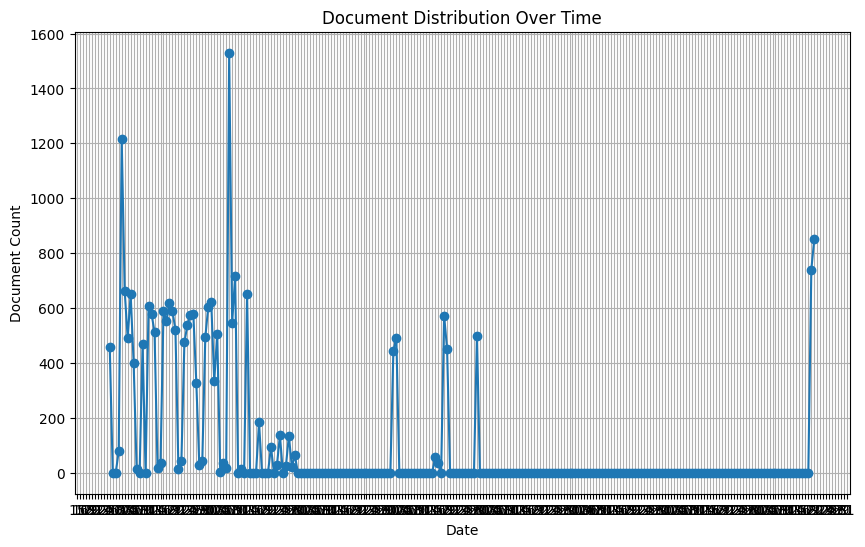

In [13]:
document_distribution_over_time()